In [1]:
import pandas
import numpy.random
import vtreat
import sklearn.linear_model
import sklearn.metrics
import seaborn
import matplotlib.pyplot
import statsmodels.api
import scipy.stats
import re


In [2]:
n_rows = 5000
n_signal_variables = 10
n_noise_variables = 100
n_levels = 500

In [3]:
d = pandas.DataFrame({"y":0.01*numpy.random.normal(size = n_rows)})

In [4]:
def mk_var_values(n_levels):
    values = {}
    for i in range(n_levels):
        values["level_" + str(i)] = numpy.random.uniform(low=-10, high=10, size=1)[0]
    return values

In [5]:
for i in range(n_signal_variables):
    var_name = "var_" + str(i)
    levs = mk_var_values(n_levels)
    keys = [ k for k in levs.keys() ]
    observed = [ keys[i] for i in numpy.random.choice(len(keys), size=n_rows, replace=True)]
    effect = numpy.asarray([ levs[k] for k in observed ])
    d[var_name] = observed
    d["y"] = d["y"] + effect

In [6]:
for i in range(n_noise_variables):
    var_name = "noise_" + str(i)
    levs = mk_var_values(n_levels)
    keys = [ k for k in levs.keys() ]
    observed = [ keys[i] for i in numpy.random.choice(len(keys), size=n_rows, replace=True)]
    d[var_name] = observed

In [7]:
d.head()

,y,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,noise_90,noise_91,noise_92,noise_93,noise_94,noise_95,noise_96,noise_97,noise_98,noise_99
0,1.383513,level_352,level_101,level_48,level_309,level_474,level_52,level_96,level_24,level_104,...,level_363,level_193,level_34,level_312,level_452,level_335,level_385,level_128,level_26,level_309
1,-0.026570,level_26,level_167,level_291,level_167,level_143,level_384,level_184,level_484,level_410,...,level_5,level_224,level_371,level_36,level_120,level_427,level_436,level_117,level_214,level_173
2,27.258577,level_297,level_424,level_50,level_433,level_192,level_254,level_390,level_386,level_262,...,level_38,level_179,level_153,level_325,level_288,level_117,level_363,level_307,level_403,level_397
3,12.502685,level_449,level_83,level_491,level_371,level_296,level_208,level_372,level_436,level_136,...,level_470,level_382,level_79,level_198,level_221,level_82,level_28,level_41,level_69,level_498
4,16.899068,level_385,level_274,level_259,level_406,level_419,level_442,level_435,level_69,level_486,...,level_423,level_155,level_165,level_111,level_235,level_3,level_104,level_477,level_68,level_199


In [8]:
is_train = numpy.random.uniform(size=n_rows)<=0.5

In [9]:
d_train = d.loc[is_train,:].copy()
d_train.reset_index(inplace=True, drop=True)
y_train = numpy.asarray(d_train["y"])
d_train.drop(["y"], axis=1, inplace=True)
d_test = d.loc[numpy.logical_not(is_train),:].copy()
d_test.reset_index(inplace=True, drop=True)
y_test = numpy.asarray(d_test["y"])
d_test.drop(["y"], axis=1, inplace=True)

In [10]:
plan = vtreat.NumericOutcomeTreatment(params=vtreat.vtreat_parameters({'filter_to_recommended':False,
                                                                       'coders':['impact_code']}))
cross_frame = plan.fit_transform(d_train, y_train)
prepared_test = plan.transform(d_test)
naive_train_hierarchical = plan.transform(d_train)

In [11]:
p2 = vtreat.NumericOutcomeTreatment(params=vtreat.vtreat_parameters({'filter_to_recommended':False,
                                                                     'coders':['impact_code'],
                                                                     'use_hierarchical_estimate':False}))
p2.fit_transform(d_train, y_train)
naive_train_empirical = p2.transform(d_train)

In [12]:
naive_train_empirical.head()

,var_0_impact_code,var_1_impact_code,var_2_impact_code,var_3_impact_code,var_4_impact_code,var_5_impact_code,var_6_impact_code,var_7_impact_code,var_8_impact_code,var_9_impact_code,...,noise_90_impact_code,noise_91_impact_code,noise_92_impact_code,noise_93_impact_code,noise_94_impact_code,noise_95_impact_code,noise_96_impact_code,noise_97_impact_code,noise_98_impact_code,noise_99_impact_code
0,-11.684808,-18.477390,6.801226,17.629075,2.982388,4.588775,-4.962607,1.169723,11.835071,-2.951798,...,-10.828920,0.019370,5.755351,-1.725535,-9.240895,7.420990,-11.527138,-1.127728,-5.007127,0.373246
1,-23.375041,9.870295,6.085724,5.484843,10.598310,14.951526,10.611742,0.333619,11.242828,6.782952,...,9.312092,4.284838,8.441365,-9.045142,-0.053117,-4.577667,12.756304,9.386368,4.219720,-1.614600
2,16.036522,2.468665,2.632923,2.496307,13.086242,-2.276703,-4.466609,3.039245,5.604963,0.497867,...,2.466489,2.644322,14.700274,4.121955,14.715039,5.481840,1.811169,0.878590,-3.501312,9.886655
3,-8.134826,0.657330,3.422340,0.976318,-6.963903,-3.528208,2.646056,-7.726300,1.340601,-3.991396,...,-4.460876,4.853681,8.687255,3.428803,1.385715,-13.991781,-12.372685,-10.019619,0.448116,-5.343279
4,13.835043,4.758503,0.302671,6.721130,1.771526,-12.802620,3.487949,4.072454,-8.989508,6.145415,...,-0.438651,-0.604513,2.417146,11.634948,5.382935,-0.739027,-5.140218,-2.147282,-4.231404,-14.797894


In [13]:
naive_train_hierarchical.head()

,var_0_impact_code,var_1_impact_code,var_2_impact_code,var_3_impact_code,var_4_impact_code,var_5_impact_code,var_6_impact_code,var_7_impact_code,var_8_impact_code,var_9_impact_code,...,noise_90_impact_code,noise_91_impact_code,noise_92_impact_code,noise_93_impact_code,noise_94_impact_code,noise_95_impact_code,noise_96_impact_code,noise_97_impact_code,noise_98_impact_code,noise_99_impact_code
0,-6.922003,-10.204846,4.498360,3.225548,2.137947,2.793662,-4.309458,1.035947,9.147490,-2.488887,...,-4.839085,0.012283,4.007744,-1.116215,-5.657213,5.113925,-8.925330,-0.616798,-4.639828,0.239002
1,-10.205297,7.973106,4.011322,4.404550,9.972326,9.931526,5.974046,0.187770,8.255927,5.897103,...,8.798308,1.883913,4.974202,-2.921928,-0.036870,-3.184418,0.000000,7.551188,2.175405,-1.197707
2,9.570785,1.857906,2.022711,1.808472,9.770240,-1.920170,-2.021494,1.846224,2.793820,0.248783,...,1.755253,1.177430,10.151408,2.216398,10.093101,4.168719,1.402266,0.505821,-0.623865,7.419761
3,-5.914109,0.319000,2.421041,0.853791,-4.456241,-2.976404,2.377143,-5.417539,1.201333,-3.407620,...,-3.547500,4.466916,4.693266,2.450456,0.823708,-8.452016,-8.078761,-4.850079,0.222080,-3.254473
4,8.169779,2.310153,0.145656,5.000864,0.789880,-6.448085,2.508478,2.617945,-5.990377,3.917369,...,-0.208001,-0.467094,1.137206,6.845210,0.868897,-0.579928,-2.843802,-0.635050,-2.623697,-3.766177


In [14]:
cross_frame.head()

,var_0_impact_code,var_1_impact_code,var_2_impact_code,var_3_impact_code,var_4_impact_code,var_5_impact_code,var_6_impact_code,var_7_impact_code,var_8_impact_code,var_9_impact_code,...,noise_90_impact_code,noise_91_impact_code,noise_92_impact_code,noise_93_impact_code,noise_94_impact_code,noise_95_impact_code,noise_96_impact_code,noise_97_impact_code,noise_98_impact_code,noise_99_impact_code
0,-5.322267,-15.999631,1.893563,5.551115e-17,4.961150e+00,3.013425,-9.614742,-0.447051,3.989984e+00,0.000000,...,-5.917140,-0.191053,6.893068,-3.579628,-20.043028,3.516064,-10.185356,-4.816471,-6.188825,1.924721
1,-22.195557,4.387807,1.792151,6.014366e+00,7.136561e+00,12.898983,2.057459,-11.425445,6.468179e+00,0.000000,...,7.597271,0.451719,4.553115,-2.418727,-2.382286,-5.694873,0.000000,6.317929,-5.062048,-8.481378
2,4.753891,-2.452018,-1.008761,-2.298021e+00,0.000000e+00,-4.826413,-6.702588,0.031657,-2.932530e+00,-1.410207,...,1.414789,-2.777331,8.245171,1.179748,5.124789,-0.471257,-4.123788,-3.408455,-0.056268,5.054761
3,0.000000,-0.087741,3.335645,5.551115e-17,-4.011519e+00,-4.878556,1.902082,-8.515607,-5.551115e-17,-3.783779,...,-4.105557,5.946857,0.270925,2.089126,3.905227,-16.358475,-7.568151,-4.497116,0.169481,-11.246009
4,0.000000,2.414175,-0.914418,3.074964e+00,5.551115e-17,-11.875552,0.864088,0.395670,-9.489654e+00,2.649852,...,-0.282157,-4.193109,-1.587273,0.694894,0.000000,-1.325272,-2.810178,-8.803324,-6.757839,-11.492468


In [15]:
all_vars = [vi for vi in plan.score_frame_["variable"]]
corr_frame = pandas.DataFrame({"variable":[vi for vi in all_vars if re.match(".*_impact_.*", vi)]})
corr_frame["naive_train_empirical_correlation"] = [ 
    scipy.stats.pearsonr(naive_train_empirical[vi], y_train)[0] for vi in corr_frame["variable"]]
corr_frame["naive_train_hierarchical_correlation"] = [ 
    scipy.stats.pearsonr(naive_train_hierarchical[vi], y_train)[0] for vi in corr_frame["variable"]]
corr_frame["cross_frame_correlation"] = [ 
    scipy.stats.pearsonr(cross_frame[vi], y_train)[0] for vi in corr_frame["variable"]]
corr_frame["test_correlation"] = [ 
    scipy.stats.pearsonr(prepared_test[vi], y_test)[0] for vi in corr_frame["variable"]]
corr_frame["is_noise"] = [re.match("^noise_.*", vi) is not None for vi in corr_frame["variable"]]
corr_frame


,variable,naive_train_empirical_correlation,naive_train_hierarchical_correlation,cross_frame_correlation,test_correlation,is_noise
0,var_0_impact_code,0.537988,0.516793,0.187620,0.166293,False
1,var_1_impact_code,0.529995,0.500877,0.159943,0.129622,False
2,var_2_impact_code,0.524644,0.498001,0.130256,0.198606,False
3,var_3_impact_code,0.534853,0.509648,0.187316,0.162451,False
4,var_4_impact_code,0.541740,0.518620,0.196953,0.197392,False
5,var_5_impact_code,0.510184,0.481632,0.148966,0.175461,False
6,var_6_impact_code,0.495153,0.467347,0.115854,0.168722,False
7,var_7_impact_code,0.534236,0.509114,0.168382,0.168450,False
8,var_8_impact_code,0.519112,0.496166,0.146696,0.175128,False
9,var_9_impact_code,0.501486,0.477278,0.125437,0.161875,False


(0.8552856382584195, 1.295641205227952e-32)


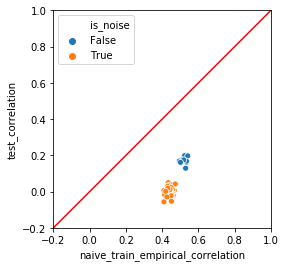

In [16]:
print(scipy.stats.pearsonr(corr_frame['naive_train_empirical_correlation'], corr_frame['test_correlation']))
seaborn.scatterplot(x = "naive_train_empirical_correlation", y = "test_correlation", data = corr_frame, hue = "is_noise")
matplotlib.pyplot.plot([-1, 1], [-1, 1], color="red")
matplotlib.pyplot.xlim(-.2,1)
matplotlib.pyplot.ylim(-.2,1)
matplotlib.pyplot.gca().set_aspect('equal', adjustable='box')

(0.85747877102484, 6.0391214806109486e-33)


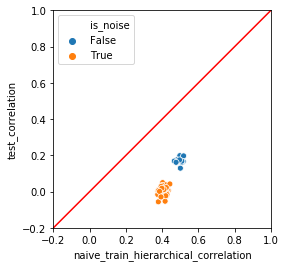

In [17]:
print(scipy.stats.pearsonr(corr_frame['naive_train_hierarchical_correlation'], corr_frame['test_correlation']))
seaborn.scatterplot(x = "naive_train_hierarchical_correlation", y = "test_correlation", data = corr_frame, hue = "is_noise")
matplotlib.pyplot.plot([-1, 1], [-1, 1], color="red")
matplotlib.pyplot.xlim(-.2,1)
matplotlib.pyplot.ylim(-.2,1)
matplotlib.pyplot.gca().set_aspect('equal', adjustable='box')

(0.8278827854397146, 6.985268378478407e-29)


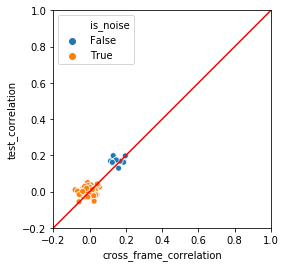

In [18]:
print(scipy.stats.pearsonr(corr_frame['cross_frame_correlation'], corr_frame['test_correlation']))
seaborn.scatterplot(x = "cross_frame_correlation", y = "test_correlation", data = corr_frame,  hue = "is_noise")
matplotlib.pyplot.plot([-1, 1], [-1, 1], color="red")
matplotlib.pyplot.xlim(-.2,1)
matplotlib.pyplot.ylim(-.2,1)
matplotlib.pyplot.gca().set_aspect('equal', adjustable='box')

In [19]:
plan.score_frame_.tail()

,variable,treatment,y_aware,has_range,PearsonR,significance,vcount,recommended
105,noise_95_impact_code,impact_code,True,True,-0.013341,0.499015,110.0,False
106,noise_96_impact_code,impact_code,True,True,0.015183,0.441665,110.0,False
107,noise_97_impact_code,impact_code,True,True,-0.016899,0.391818,110.0,False
108,noise_98_impact_code,impact_code,True,True,-0.038401,0.051592,110.0,False
109,noise_99_impact_code,impact_code,True,True,-0.009541,0.628779,110.0,False


In [20]:
recommended_vars = [vi for vi in plan.score_frame_["variable"][plan.score_frame_["recommended"]]]
recommended_vars

['var_0_impact_code',
 'var_1_impact_code',
 'var_2_impact_code',
 'var_3_impact_code',
 'var_4_impact_code',
 'var_5_impact_code',
 'var_6_impact_code',
 'var_7_impact_code',
 'var_8_impact_code',
 'var_9_impact_code',
 'noise_18_impact_code']

In [21]:
plot_train = pandas.DataFrame({"y":y_train})
plot_test = pandas.DataFrame({"y":y_test})

In [22]:
fitter = sklearn.linear_model.LinearRegression(fit_intercept = True)

In [23]:
fitter.fit(cross_frame[all_vars], y_train)
plot_train["predict_cross_all_vars"] = fitter.predict(cross_frame[all_vars])
plot_test["predict_cross_all_vars"] = fitter.predict(prepared_test[all_vars])

In [24]:
fitter.fit(cross_frame[recommended_vars], y_train)
plot_train["predict_cross_recommended_vars"] = fitter.predict(cross_frame[recommended_vars])
plot_test["predict_cross_recommended_vars"] = fitter.predict(prepared_test[recommended_vars])

In [25]:
fitter.fit(naive_train_empirical[all_vars], y_train)
plot_train["predict_naive_empirical_all_vars"] = fitter.predict(naive_train_empirical[all_vars])
plot_test["predict_naive_empirical_all_vars"] = fitter.predict(prepared_test[all_vars])

In [26]:
fitter.fit(naive_train_hierarchical[all_vars], y_train)
plot_train["predict_naive_hierarchical_all_vars"] = fitter.predict(naive_train_hierarchical[all_vars])
plot_test["predict_naive_hierarchical_all_vars"] = fitter.predict(prepared_test[all_vars])

In [27]:
plot_test.head()

,y,predict_cross_all_vars,predict_cross_recommended_vars,predict_naive_empirical_all_vars,predict_naive_hierarchical_all_vars
0,-0.026570,1.494868,0.810747,1.532900,0.778234
1,27.258577,3.548667,1.247861,0.085402,-0.663297
2,16.899068,0.807263,-0.755245,-0.520152,-1.183128
3,-0.028523,10.112324,2.623343,2.602956,4.702430
4,23.936118,-12.158877,-15.492469,-7.039041,-11.418475


In [28]:
def rmse(x, y):
    return numpy.sqrt(numpy.mean((x-y)**2))

3.206479233301278


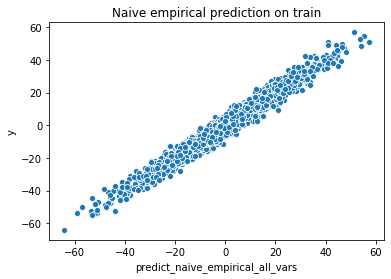

In [29]:
print(rmse(plot_train["predict_naive_empirical_all_vars"], plot_train["y"]))
seaborn.scatterplot(x="predict_naive_empirical_all_vars", y ="y", data = plot_train)
plt = matplotlib.pyplot.title("Naive empirical prediction on train")

4.651747067091252


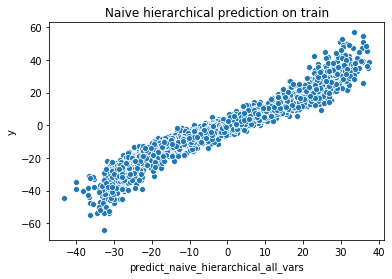

In [30]:
print(rmse(plot_train["predict_naive_hierarchical_all_vars"], plot_train["y"]))
seaborn.scatterplot(x="predict_naive_hierarchical_all_vars", y ="y", data = plot_train)
plt = matplotlib.pyplot.title("Naive hierarchical prediction on train")

15.42621122814677


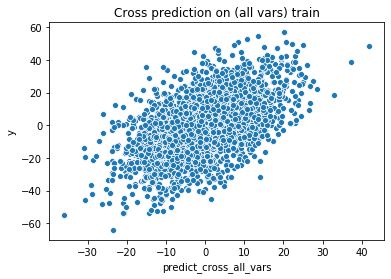

In [31]:
print(rmse(plot_train["predict_cross_all_vars"], plot_train["y"]))
seaborn.scatterplot(x="predict_cross_all_vars", y ="y", data = plot_train)
plt = matplotlib.pyplot.title("Cross prediction on (all vars) train")

15.872204115447927


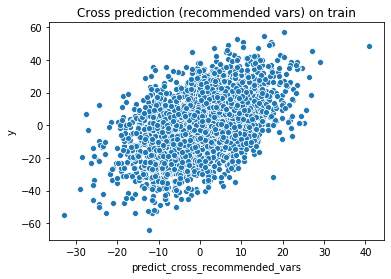

In [32]:
print(rmse(plot_train["predict_cross_recommended_vars"], plot_train["y"]))
seaborn.scatterplot(x="predict_cross_recommended_vars", y ="y", data = plot_train)
plt = matplotlib.pyplot.title("Cross prediction (recommended vars) on train")

17.5439880598221


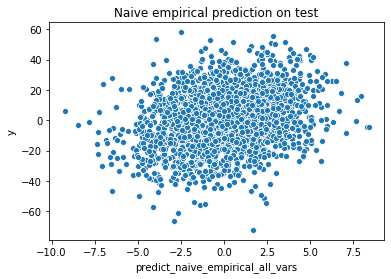

In [33]:
print(rmse(plot_test["predict_naive_empirical_all_vars"], plot_test["y"]))
seaborn.scatterplot(x="predict_naive_empirical_all_vars", y ="y", data = plot_test)
plt = matplotlib.pyplot.title("Naive empirical prediction on test")

17.2340552407076


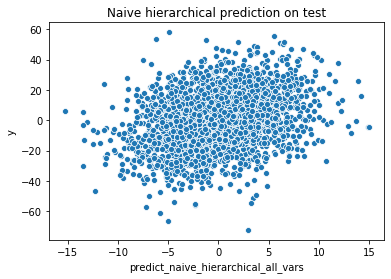

In [34]:
print(rmse(plot_test["predict_naive_hierarchical_all_vars"], plot_test["y"]))
seaborn.scatterplot(x="predict_naive_hierarchical_all_vars", y ="y", data = plot_test)
plt = matplotlib.pyplot.title("Naive hierarchical prediction on test")

15.65079425480502


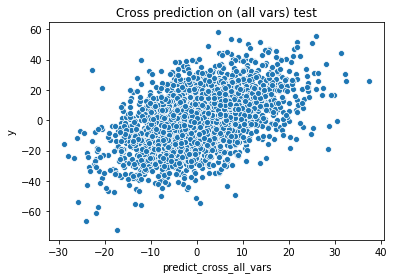

In [35]:
print(rmse(plot_test["predict_cross_all_vars"], plot_test["y"]))
seaborn.scatterplot(x="predict_cross_all_vars", y ="y", data = plot_test)
plt = matplotlib.pyplot.title("Cross prediction on (all vars) test")

15.262015123521905


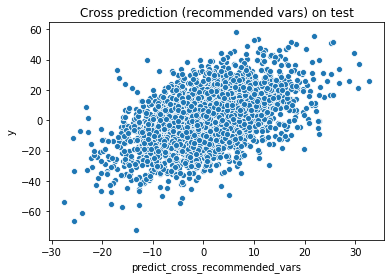

In [36]:
print(rmse(plot_test["predict_cross_recommended_vars"], plot_test["y"]))
seaborn.scatterplot(x="predict_cross_recommended_vars", y ="y", data = plot_test)
plt = matplotlib.pyplot.title("Cross prediction (recommended vars) on test")

In [37]:
smf1 = statsmodels.api.OLS(
    y_train, 
    statsmodels.api.add_constant(naive_train_empirical[all_vars])).fit()
smf1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.969
Model:                            OLS   Adj. R-squared:                  0.968
Method:                 Least Squares   F-statistic:                     707.8
Date:                Thu, 25 Jul 2019   Prob (F-statistic):               0.00
Time:                        16:09:07   Log-Likelihood:                -6641.2
No. Observations:                2570   AIC:                         1.350e+04
Df Residuals:                    2459   BIC:                         1.415e+04
Df Model:                         110                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -0.2536      0.065     -3.922      0.000      -0.380      -0.127
var_0_impact_code        0.0489      0.008      6.165      0.000       0.033       0.064
var_1_impact_code        0.0747      0.008      9.475      0.000       0.059       0.090
var_2_impact_code        0.0541      0.008      6.767      0.000       0.038       0.070
var_3_impact_code        0.0800      0.008     10.088      0.000       0.064       0.096
var_4_impact_code        0.0519      0.008      6.609      0.000       0.037       0.067
var_5_impact_code        0.0729      0.008      8.946      0.000       0.057       0.089
var_6_impact_code        0.0570      0.008      6.826      0.000       0.041       0.073
var_7_impact_code        0.0712      0.008      8.917      0.000       0.056       0.087
var_8_impact_code        0.0612      0.008      7.582      0.000       0.045       0.077
var_9_impact_code        0.0697      0.008      8.442      0.000       0.054       0.086
noise_0_impact_code      0.0427      0.009      4.743      0.000       0.025       0.060
noise_1_impact_code      0.0262      0.009      2.841      0.005       0.008       0.044
noise_2_impact_code      0.0469      0.009      5.042      0.000       0.029       0.065
noise_3_impact_code      0.0365      0.009      3.952      0.000       0.018       0.055
noise_4_impact_code      0.0400      0.009      4.415      0.000       0.022       0.058
noise_5_impact_code      0.0528      0.009      5.906      0.000       0.035       0.070
noise_6_impact_code      0.0468      0.009      5.066      0.000       0.029       0.065
noise_7_impact_code      0.0401      0.009      4.498      0.000       0.023       0.058
noise_8_impact_code      0.0407      0.009      4.515      0.000       0.023       0.058
noise_9_impact_code      0.0416      0.009      4.633      0.000       0.024       0.059
noise_10_impact_code     0.0449      0.009      4.988      0.000       0.027       0.063
noise_11_impact_code     0.0235      0.009      2.580      0.010       0.006       0.041
noise_12_impact_code     0.0538      0.009      6.017      0.000       0.036       0.071
noise_13_impact_code     0.0353      0.009      3.840      0.000       0.017       0.053
noise_14_impact_code     0.0432      0.009      4.700      0.000       0.025       0.061
noise_15_impact_code     0.0378      0.009      4.339      0.000       0.021       0.055
noise_16_impact_code     0.0209      0.009      2.338      0.019       0.003       0.038
noise_17_impact_code     0.0482      0.009      5.289      0.000       0.030       0.066
noise_18_impact_code     0.0366      0.009      4.152      0.000       0.019       0.054
noise_19_impact_code     0.0325      0.009      3.434      0.001       0.014       0.051
noise_20_impact_code     0.0577      0.009      6.282    

In [38]:
sklearn.metrics.r2_score(plot_train["y"],plot_train["predict_naive_empirical_all_vars"])

0.9693835710295952

In [39]:
sklearn.metrics.r2_score(plot_test["y"],plot_test["predict_naive_empirical_all_vars"])

0.05366921439362193

In [40]:
smf2 = statsmodels.api.OLS(
    y_train, 
    statsmodels.api.add_constant(cross_frame[all_vars])).fit()
smf2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.291
Model:                            OLS   Adj. R-squared:                  0.260
Method:                 Least Squares   F-statistic:                     9.192
Date:                Thu, 25 Jul 2019   Prob (F-statistic):          1.64e-117
Time:                        16:09:08   Log-Likelihood:                -10678.
No. Observations:                2570   AIC:                         2.158e+04
Df Residuals:                    2459   BIC:                         2.223e+04
Df Model:                         110                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -0.1245      0.317     -0.393      0.694      -0.745       0.496
var_0_impact_code        0.4625      0.046     10.045      0.000       0.372       0.553
var_1_impact_code        0.4429      0.047      9.402      0.000       0.351       0.535
var_2_impact_code        0.3366      0.046      7.287      0.000       0.246       0.427
var_3_impact_code        0.4816      0.047     10.290      0.000       0.390       0.573
var_4_impact_code        0.4732      0.047     10.057      0.000       0.381       0.566
var_5_impact_code        0.3946      0.048      8.176      0.000       0.300       0.489
var_6_impact_code        0.3712      0.052      7.079      0.000       0.268       0.474
var_7_impact_code        0.4735      0.047     10.153      0.000       0.382       0.565
var_8_impact_code        0.3970      0.048      8.226      0.000       0.302       0.492
var_9_impact_code        0.3714      0.049      7.651      0.000       0.276       0.467
noise_0_impact_code      0.0663      0.056      1.182      0.237      -0.044       0.176
noise_1_impact_code     -0.0177      0.058     -0.307      0.759      -0.131       0.095
noise_2_impact_code     -0.0862      0.060     -1.445      0.149      -0.203       0.031
noise_3_impact_code     -0.0272      0.058     -0.468      0.640      -0.141       0.087
noise_4_impact_code      0.0094      0.058      0.162      0.871      -0.105       0.123
noise_5_impact_code      0.0078      0.057      0.137      0.891      -0.104       0.119
noise_6_impact_code      0.0567      0.059      0.957      0.339      -0.059       0.173
noise_7_impact_code      0.0005      0.057      0.009      0.993      -0.111       0.112
noise_8_impact_code      0.0857      0.060      1.436      0.151      -0.031       0.203
noise_9_impact_code     -0.0472      0.056     -0.848      0.397      -0.156       0.062
noise_10_impact_code     0.0488      0.056      0.871      0.384      -0.061       0.159
noise_11_impact_code     0.0319      0.055      0.580      0.562      -0.076       0.140
noise_12_impact_code     0.0313      0.055      0.569      0.569      -0.076       0.139
noise_13_impact_code     0.0353      0.061      0.577      0.564      -0.085       0.155
noise_14_impact_code    -0.0564      0.059     -0.961      0.337      -0.171       0.059
noise_15_impact_code     0.0555      0.057      0.975      0.330      -0.056       0.167
noise_16_impact_code     0.0396      0.060      0.655      0.512      -0.079       0.158
noise_17_impact_code    -0.0097      0.057     -0.171      0.865      -0.122       0.102
noise_18_impact_code     0.1035      0.058      1.784      0.075      -0.010       0.217
noise_19_impact_code    -0.1945      0.059     -3.302      0.001      -0.310      -0.079
noise_20_impact_code     0.0286      0.058      0.494    

In [41]:
sklearn.metrics.r2_score(plot_train["y"],plot_train["predict_cross_all_vars"])

0.29137541013309876

In [42]:
sklearn.metrics.r2_score(plot_test["y"],plot_test["predict_cross_all_vars"])

0.2468888336794015

In [43]:
smf3 = statsmodels.api.OLS(
    y_train, 
    statsmodels.api.add_constant(cross_frame[recommended_vars])).fit()
smf3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.250
Model:                            OLS   Adj. R-squared:                  0.247
Method:                 Least Squares   F-statistic:                     77.44
Date:                Thu, 25 Jul 2019   Prob (F-statistic):          8.04e-151
Time:                        16:09:08   Log-Likelihood:                -10752.
No. Observations:                2570   AIC:                         2.153e+04
Df Residuals:                    2558   BIC:                         2.160e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -0.0939      0.314     -0.299      0.765      -0.710       0.522
var_0_impact_code        0.4651      0.045     10.244      0.000       0.376       0.554
var_1_impact_code        0.4441      0.046      9.600      0.000       0.353       0.535
var_2_impact_code        0.3367      0.046      7.353      0.000       0.247       0.426
var_3_impact_code        0.4906      0.046     10.638      0.000       0.400       0.581
var_4_impact_code        0.4761      0.047     10.212      0.000       0.385       0.568
var_5_impact_code        0.4259      0.048      8.924      0.000       0.332       0.520
var_6_impact_code        0.3729      0.052      7.205      0.000       0.271       0.474
var_7_impact_code        0.4522      0.046      9.820      0.000       0.362       0.543
var_8_impact_code        0.3966      0.048      8.296      0.000       0.303       0.490
var_9_impact_code        0.3869      0.048      8.022      0.000       0.292       0.482
noise_18_impact_code     0.1083      0.057      1.894      0.058      -0.004       0.221
==============================================================================
Omnibus:                        4.406   Durbin-Watson:                   2.011
Prob(Omnibus):                  0.110   Jarque-Bera (JB):                3.836
Skew:                          -0.009   Prob(JB):                        0.147
Kurtosis:                       2.812   Cond. No.                         7.11
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [44]:
sklearn.metrics.r2_score(plot_train["y"],plot_train["predict_cross_recommended_vars"])

0.24980847983124788

In [45]:
sklearn.metrics.r2_score(plot_test["y"],plot_test["predict_cross_recommended_vars"])

0.28383996531300304